# Time series analysis on AWS
*Chapter 1 - Time series analysis overview*

## Initializations
---

In [1]:
!pip install --quiet tqdm kaggle tsia

### Imports

In [59]:
import matplotlib.colors as mpl_colors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import tsia
import warnings
import zipfile

from matplotlib import gridspec
from sklearn.preprocessing import normalize
from tqdm import tqdm
from urllib.request import urlretrieve

### Parameters

In [376]:
RAW_DATA = os.path.join('data', 'raw')
DATA = 'data'
warnings.filterwarnings("ignore")

%matplotlib inline
# plt.style.use('Solarize_Light2')
plt.style.use('fivethirtyeight')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['lines.linewidth'] = 0.3
plt.rcParams['axes.titlesize'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 4
plt.rcParams['ytick.labelsize'] = 4
plt.rcParams['grid.linewidth'] = 0.2
plt.rcParams['legend.fontsize'] = 5

### Helper functions

In [4]:
def progress_report_hook(count, block_size, total_size):
    mb = int(count * block_size // 1048576)
    if count % 500 == 0:
        sys.stdout.write("\r{} MB downloaded".format(mb))
        sys.stdout.flush()

### Downloading datasets

#### **Dataset 1:** Household energy consumption

In [5]:
ORIGINAL_DATA = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip'
ARCHIVE_PATH  = os.path.join(RAW_DATA, 'energy-consumption.zip')
FILE_NAME     = 'energy-consumption.csv'
FILE_PATH     = os.path.join(DATA, 'energy', FILE_NAME)
FILE_DIR      = os.path.dirname(FILE_PATH)

if not os.path.isfile(FILE_PATH):
    print("Downloading dataset (258MB), can take a few minutes depending on your connection")
    urlretrieve(ORIGINAL_DATA, ARCHIVE_PATH, reporthook=progress_report_hook)
    os.makedirs('./data/energy', exist_ok=True)

    print("\nExtracting data archive")
    zip_ref = zipfile.ZipFile(ARCHIVE_PATH, 'r')
    zip_ref.extractall(FILE_DIR + '/')
    zip_ref.close()
    
    !rm -Rf ./data/energy/__MACOSX
    !mv ./data/energy/LD2011_2014.txt $FILE_PATH
    
else:
    print("File found, skipping download")

File found, skipping download


#### **Dataset 2:** Nasa Turbofan remaining useful lifetime

In [6]:
ok = True
ok = ok and os.path.exists('./data/turbofan/train_FD001.txt')
ok = ok and os.path.exists('./data/turbofan/test_FD001.txt')
ok = ok and os.path.exists('./data/turbofan/RUL_FD001.txt')

if (ok):
    print("File found, skipping download")

else:
    print('Some datasets are missing, create working directories and download original dataset from the NASA repository.')
    
    # Making sure the directory already exists:
    os.makedirs('./data/turbofan', exist_ok=True)

    # Download the dataset from the NASA repository, unzip it and set
    # aside the first training file to work on:
    !wget https://ti.arc.nasa.gov/c/6/ --output-document=./data/raw/CMAPSSData.zip
    !unzip ./data/raw/CMAPSSData.zip -d ./data/raw
    !cp ./data/raw/train_FD001.txt ./data/turbofan/train_FD001.txt
    !cp ./data/raw/test_FD001.txt ./data/turbofan/test_FD001.txt
    !cp ./data/raw/RUL_FD001.txt ./data/turbofan/RUL_FD001.txt

File found, skipping download


#### **Dataset 3:** Human heartbeat

In [7]:
ECG_DATA_SOURCE = 'http://www.timeseriesclassification.com/Downloads/ECG200.zip'
ARCHIVE_PATH  = os.path.join(RAW_DATA, 'ECG200.zip')
FILE_NAME     = 'ecg.csv'
FILE_PATH     = os.path.join(DATA, 'ecg', FILE_NAME)
FILE_DIR      = os.path.dirname(FILE_PATH)

if not os.path.isfile(FILE_PATH):
    urlretrieve(ECG_DATA_SOURCE, ARCHIVE_PATH)
    os.makedirs('./data/ecg', exist_ok=True)

    print("\nExtracting data archive")
    zip_ref = zipfile.ZipFile(ARCHIVE_PATH, 'r')
    zip_ref.extractall(FILE_DIR + '/')
    zip_ref.close()
    
#     !rm -Rf ./data/energy/__MACOSX
    !mv ./data/ecg/ECG200_TRAIN.txt $FILE_PATH
    
else:
    print("File found, skipping download")

File found, skipping download


#### **Dataset 4:** Industrial pump data
To download this dataset from Kaggle, you will need to have an account and create a token that you install on your machine. You can follow [**this link**](https://www.kaggle.com/docs/api) to get started with the Kaggle API. Once generated, make sure your Kaggle token is stored in the `~/.kaggle/kaggle.json` file, or the next cells will issue an error. To get a Kaggle token, go to kaggle.com and create an account. Then navigate to **My account** and scroll down to the API section. There, click the **Create new API token** button:

<img src="assets/kaggle_api.png" />


In [50]:
FILE_NAME    = 'pump-sensor-data.zip'
ARCHIVE_PATH = os.path.join(RAW_DATA, FILE_NAME)
FILE_PATH    = os.path.join(DATA, 'pump', 'sensor.csv')
FILE_DIR     = os.path.dirname(FILE_PATH)

if not os.path.isfile(FILE_PATH):
    if not os.path.exists('/home/ec2-user/.kaggle/kaggle.json'):
        print('The kaggle.json token was not found.\nCreating the /home/ec2-user/.kaggle/ directory: put your kaggle.json file there once you have generated it from the Kaggle website')
        os.makedirs('/home/ec2-user/.kaggle/', exist_ok=True)
    else:
        print('The kaggle.json token file was found: making sure it is not readable by other users on this system.')
        !chmod 600 /home/ec2-user/.kaggle/kaggle.json

    os.makedirs('./data/pump', exist_ok=True)
    !kaggle datasets download -d nphantawee/pump-sensor-data -p $RAW_DATA

    print("\nExtracting data archive")
    zip_ref = zipfile.ZipFile(ARCHIVE_PATH, 'r')
    zip_ref.extractall(FILE_DIR + '/')
    zip_ref.close()
    
else:
    print("File found, skipping download")

File found, skipping download


#### **Dataset 5:** London household energy consumption with weather data

In [5]:
FILE_NAME    = 'smart-meters-in-london.zip'
ARCHIVE_PATH = os.path.join(RAW_DATA, FILE_NAME)
FILE_PATH    = os.path.join(DATA, 'energy-london', 'smart-meters-in-london.zip')
FILE_DIR     = os.path.dirname(FILE_PATH)

# Checks if the data were already downloaded:
if os.path.exists(os.path.join(DATA, 'energy-london', 'acorn_details.csv')):
    print("File found, skipping download")
    
else:
    # Downloading and unzipping datasets from Kaggle:
    print("Downloading dataset (2.26G), can take a few minutes depending on your connection")
    os.makedirs(os.path.join(DATA, 'energy-london'), exist_ok=True)
    !kaggle datasets download -d jeanmidev/smart-meters-in-london -p $RAW_DATA
    
    print('Unzipping files...')
    zip_ref = zipfile.ZipFile(ARCHIVE_PATH, 'r')
    zip_ref.extractall(FILE_DIR + '/')
    zip_ref.close()
    
    !rm $DATA/energy-london/*zip
    !rm $DATA/energy-london/*gz
    !mv $DATA/energy-london/halfhourly_dataset/halfhourly_dataset/* $DATA/energy-london/halfhourly_dataset
    !rm -Rf $DATA/energy-london/halfhourly_dataset/halfhourly_dataset
    !mv $DATA/energy-london/daily_dataset/daily_dataset/* $DATA/energy-london/daily_dataset
    !rm -Rf $DATA/energy-london/daily_dataset/daily_dataset

File found, skipping download


## Dataset visualization
---

### **1.** Household energy consumption

In [10]:
%%time

FILE_PATH = os.path.join(DATA, 'energy', 'energy-consumption.csv')
energy_df = pd.read_csv(FILE_PATH, sep=';', decimal=',')
energy_df = energy_df.rename(columns={'Unnamed: 0': 'Timestamp'})
energy_df['Timestamp'] = pd.to_datetime(energy_df['Timestamp'])
energy_df = energy_df.set_index('Timestamp')
energy_df.iloc[100000:, 1:5].head()

CPU times: user 7.46 s, sys: 839 ms, total: 8.3 s
Wall time: 8.44 s


,MT_002,MT_003,MT_004,MT_005
Timestamp,,,,
2013-11-07 16:15:00,25.604552,1.737619,103.658537,43.902439
2013-11-07 16:30:00,27.027027,1.737619,91.463415,41.463415
2013-11-07 16:45:00,27.027027,1.737619,95.528455,46.341463
2013-11-07 17:00:00,26.315789,1.737619,111.788618,59.756098
2013-11-07 17:15:00,26.315789,1.737619,113.821138,60.975610


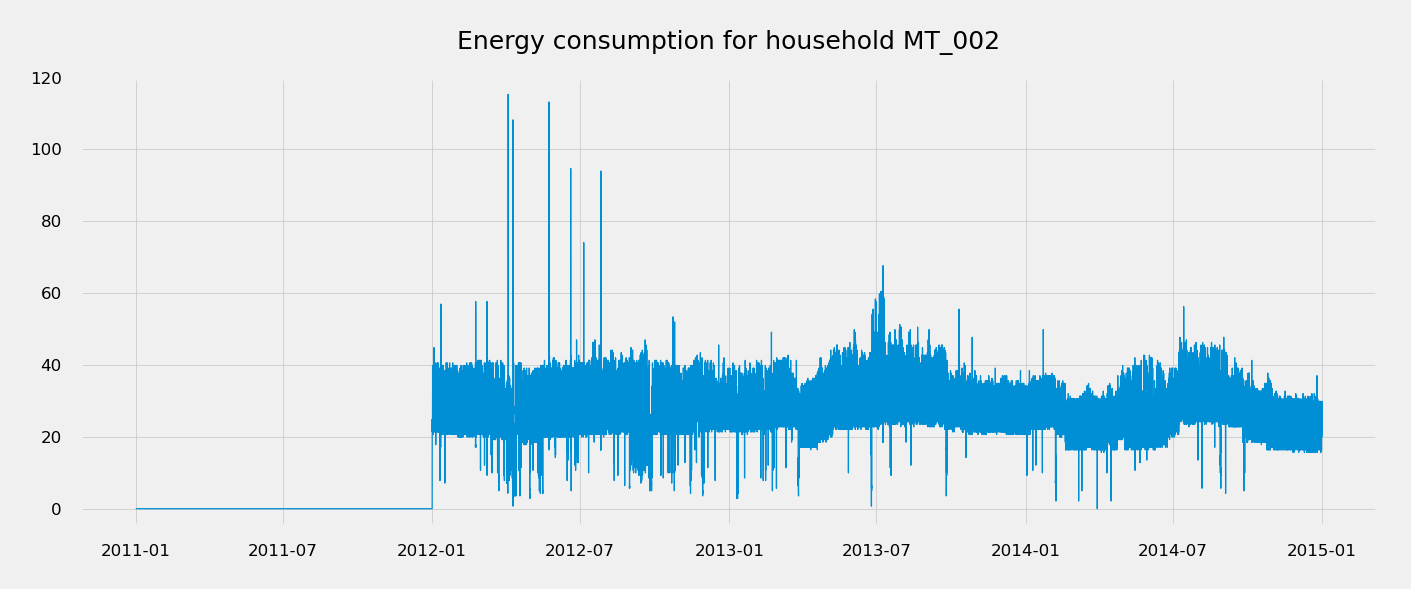

In [11]:
fig = plt.figure(figsize=(5, 1.876))
plt.plot(energy_df['MT_002'])
plt.title('Energy consumption for household MT_002')
plt.show()

### **2.** NASA Turbofan data

In [12]:
FILE_PATH = './data/turbofan/train_FD001.txt'
turbofan_df = pd.read_csv(FILE_PATH, header=None, sep=' ')
turbofan_df.dropna(axis='columns', how='all', inplace=True)
print('Shape:', turbofan_df.shape)
turbofan_df.head(5)

Shape: (20631, 26)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [13]:
columns = [
    'unit_number',
    'cycle',
    'setting_1',
    'setting_2',
    'setting_3',
] + ['sensor_{}'.format(s) for s in range(1,22)]
turbofan_df.columns = columns
turbofan_df.head()

,unit_number,cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [14]:
# Add a RUL column and group the data by unit_number:
turbofan_df['rul'] = 0
grouped_data = turbofan_df.groupby(by='unit_number')

# Loops through each unit number to get the lifecycle counts:
for unit, rul in enumerate(grouped_data.count()['cycle']):
    current_df = turbofan_df[turbofan_df['unit_number'] == (unit+1)].copy()
    current_df['rul'] = rul - current_df['cycle']
    turbofan_df[turbofan_df['unit_number'] == (unit+1)] = current_df

In [15]:
df = turbofan_df.iloc[:, [0,1,2,3,4,5,6,25,26]].copy()
df = df[df['unit_number'] == 1]

def highlight_cols(s):
    return f'background-color: rgba(0, 143, 213, 0.3)'

df.head(10).style.applymap(highlight_cols, subset=['rul'])

,unit_number,cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_21,rul
0,1,1,-0.000700,-0.000400,100.000000,518.670000,641.820000,23.419000,191
1,1,2,0.001900,-0.000300,100.000000,518.670000,642.150000,23.423600,190
2,1,3,-0.004300,0.000300,100.000000,518.670000,642.350000,23.344200,189
3,1,4,0.000700,0.000000,100.000000,518.670000,642.350000,23.373900,188
4,1,5,-0.001900,-0.000200,100.000000,518.670000,642.370000,23.404400,187
5,1,6,-0.004300,-0.000100,100.000000,518.670000,642.100000,23.366900,186
6,1,7,0.001000,0.000100,100.000000,518.670000,642.480000,23.377400,185
7,1,8,-0.003400,0.000300,100.000000,518.670000,642.560000,23.310600,184
8,1,9,0.000800,0.000100,100.000000,518.670000,642.120000,23.406600,183
9,1,10,-0.003300,0.000100,100.000000,518.670000,641.710000,23.469400,182


### **3.** ECG Data

In [227]:
FILE_PATH = './data/ecg/ecg.csv'
ecg_df = pd.read_csv(FILE_PATH, header=None, sep='  ')
print('Shape:', ecg_df.shape)
ecg_df.head()

Shape: (100, 97)


,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,-1.0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,...,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1.0,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,...,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1.0,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,...,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,-1.0,1.168874,2.075901,1.760140,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,...,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,1.0,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,...,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190


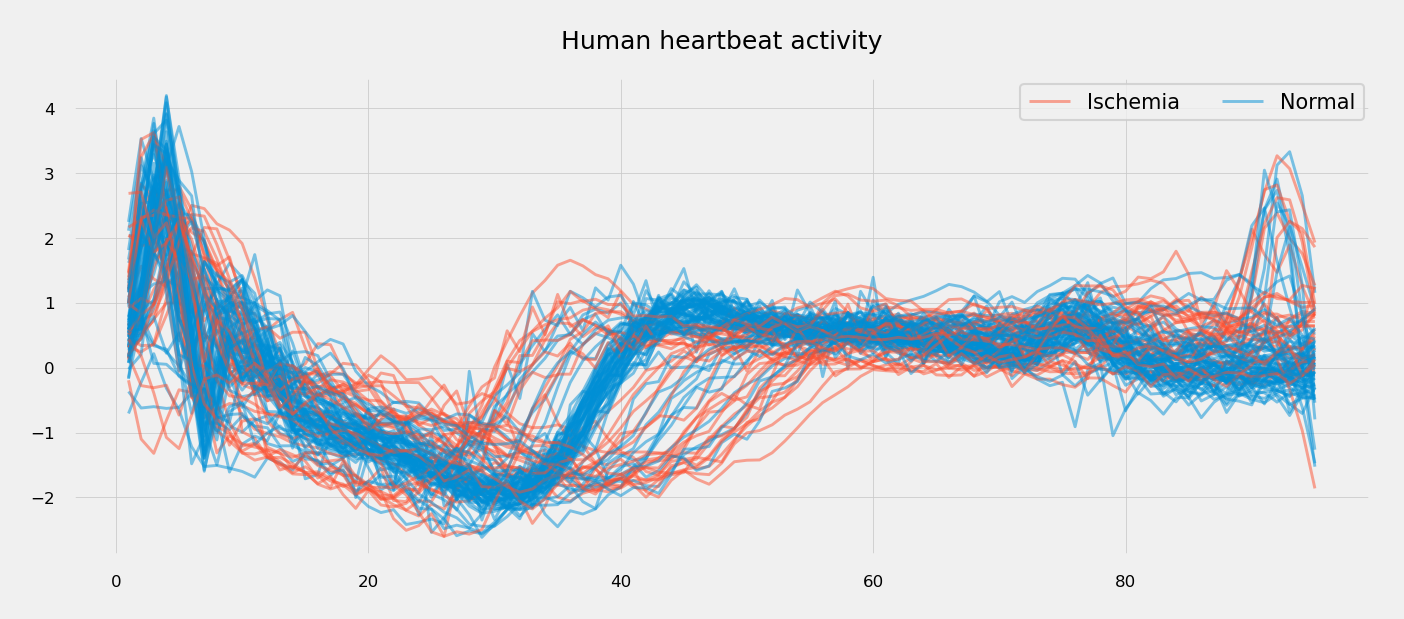

In [228]:
plt.rcParams['lines.linewidth'] = 0.7
fig = plt.figure(figsize=(5,2))
label_normal = False
label_ischemia = False
for i in range(0,100):
    label = ecg_df.iloc[i, 0]
    if (label == -1):
        color = colors[1]
        
        if label_ischemia:
            plt.plot(ecg_df.iloc[i,1:96], color=color, alpha=0.5)
        else:
            plt.plot(ecg_df.iloc[i,1:96], color=color, alpha=0.5, label='Ischemia')
            label_ischemia = True
            
    else:
        color = colors[0]
        
        if label_normal:
            plt.plot(ecg_df.iloc[i,1:96], color=color, alpha=0.5)
        else:
            plt.plot(ecg_df.iloc[i,1:96], color=color, alpha=0.5, label='Normal')
            label_normal = True
    
plt.title('Human heartbeat activity')
plt.legend(loc='upper right', ncol=2)
plt.show()

### **4.** Industrial pump data

In [53]:
FILE_PATH = './data/pump/sensor.csv'
pump_df = pd.read_csv(FILE_PATH, sep=',')
pump_df.drop(columns={'Unnamed: 0'}, inplace=True)
pump_df['timestamp'] = pd.to_datetime(pump_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
pump_df = pump_df.set_index('timestamp')

pump_df['machine_status'].replace(to_replace='NORMAL', value=np.nan, inplace=True)
pump_df['machine_status'].replace(to_replace='BROKEN', value=1, inplace=True)
pump_df['machine_status'].replace(to_replace='RECOVERING', value=1, inplace=True)

print('Shape:', pump_df.shape)
pump_df.head()

Shape: (220320, 53)


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NaN
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NaN
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NaN
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NaN
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NaN


In [54]:
file_structure_df = pump_df.iloc[:, 0:10].resample('5D').mean()

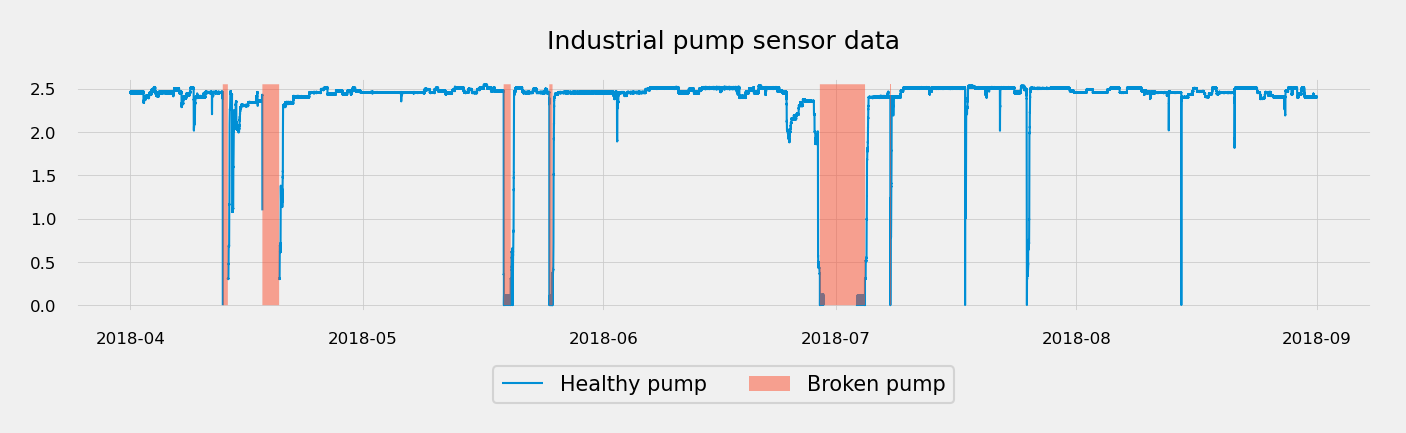

In [60]:
plt.rcParams['lines.linewidth'] = 0.5
fig = plt.figure(figsize=(5,1))
ax1 = fig.add_subplot(1,1,1)
plot1 = ax1.plot(pump_df['sensor_00'], label='Healthy pump')

ax2 = ax1.twinx()
plot2 = ax2.fill_between(x=pump_df.index, y1=0.0, y2=pump_df['machine_status'], color=colors[1], linewidth=0.0, alpha=0.5, label='Broken pump')
ax2.grid(False)
ax2.set_yticks([])

labels = [plot1[0].get_label(), plot2.get_label()]

plt.legend(handles=[plot1[0], plot2], labels=labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -.4))
plt.title('Industrial pump sensor data')
plt.show()

### **5.** London household energy consumption with weather data

We want to filter out households that are are subject to the dToU tariff and keep only the ones with a known ACORN (i.e. not in the ACORN-U group): this will allow us to better model future analysis by adding the Acorn detail informations (which by definitions, won't be available for the ACORN-U group).

In [6]:
household_filename = os.path.join(DATA, 'energy-london', 'informations_households.csv')
household_df = pd.read_csv(household_filename)
household_df = household_df[(household_df['stdorToU'] == 'Std') & (household_df['Acorn'] == 'ACORN-E')]
print(household_df.shape)
household_df.head()

(1228, 5)


,LCLid,stdorToU,Acorn,Acorn_grouped,file
627,MAC002543,Std,ACORN-E,Affluent,block_12
628,MAC002556,Std,ACORN-E,Affluent,block_12
629,MAC002660,Std,ACORN-E,Affluent,block_12
630,MAC005399,Std,ACORN-E,Affluent,block_12
631,MAC002545,Std,ACORN-E,Affluent,block_12


#### Associating households with they energy consumption data
Each household (with an ID starting by `MACxxxxx` in the table above) has its consumption data stored in a block file name `block_xx`. This file is also available from the `informations_household.csv` file extracted above. We have the association between `household_id` and `block_file`: we can open each of them and keep the consumption for the households of interest. All these data will be concatenated into an `energy_df` dataframe:

In [7]:
%%time

household_ids = household_df['LCLid'].tolist()
consumption_file = os.path.join(DATA, 'energy-london', 'hourly_consumption.csv')
min_data_points = ((pd.to_datetime('2020-12-31') - pd.to_datetime('2020-01-01')).days + 1)*24*2

if os.path.exists(consumption_file):
    print('Half-hourly consumption file already exists, loading from disk...')
    energy_df = pd.read_csv(consumption_file)
    energy_df['timestamp'] = pd.to_datetime(energy_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
    print('Done.')
    
else:
    print('Half-hourly consumption file not found. We need to generate it.')
    
    # We know have the block number we can use to open the right file:
    energy_df = pd.DataFrame()
    target_block_files = household_df['file'].unique().tolist()
    print('- {} block files to process: '.format(len(target_block_files)), end='')
    df_list = []
    for block_file in tqdm(target_block_files):
        # Reads the current block file:
        current_filename = os.path.join(DATA, 'energy-london', 'halfhourly_dataset', '{}.csv'.format(block_file))
        df = pd.read_csv(current_filename)
        
        # Set readable column names and adjust data types:
        df.columns = ['household_id', 'timestamp', 'energy']
        df = df.replace(to_replace='Null', value=0.0)
        df['energy'] = df['energy'].astype(np.float64)
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
        
        # We filter on the households sampled earlier:
        df_list.append(df[df['household_id'].isin(household_ids)].reset_index(drop=True))
    
    # Concatenate with the main dataframe:
    energy_df = pd.concat(df_list, axis='index', ignore_index=True)
    
    datapoints = energy_df.groupby(by='household_id').count()
    datapoints = datapoints[datapoints['timestamp'] < min_data_points]
    hhid_to_remove = datapoints.index.tolist()
    energy_df = energy_df[~energy_df['household_id'].isin(hhid_to_remove)]

    # Let's save this dataset to disk, we will use it from now on:
    print('Saving file to disk... ', end='')
    energy_df.to_csv(consumption_file, index=False)
    print('Done.')

Half-hourly consumption file already exists, loading from disk...
Done.
CPU times: user 18 s, sys: 1.84 s, total: 19.8 s
Wall time: 20 s


In [8]:
start = np.min(energy_df['timestamp'])
end = np.max(energy_df['timestamp'])
weather_filename = os.path.join(DATA, 'energy-london', 'weather_hourly_darksky.csv')

weather_df = pd.read_csv(weather_filename)
weather_df['time'] = pd.to_datetime(weather_df['time'], format='%Y-%m-%d %H:%M:%S')
weather_df = weather_df.drop(columns=['precipType', 'icon', 'summary'])
weather_df = weather_df.sort_values(by='time')
weather_df = weather_df.set_index('time')
weather_df = weather_df[start:end]

# Let's make sure we have one datapoint per hour to match 
# the frequency used for the household energy consumption data:
weather_df = weather_df.resample(rule='1H').mean()     # This will generate NaN values timestamp missing data
weather_df = weather_df.interpolate(method='linear')   # This will fill the missing values with the average 

print(weather_df.shape)
weather_df

(19863, 8)


,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
time,,,,,,,,
2011-11-23 10:00:00,6.24,233.0,5.74,5.46,1027.67,4.24,1.99,0.98
2011-11-23 11:00:00,10.20,233.0,7.67,5.74,1027.56,5.94,2.66,0.88
2011-11-23 12:00:00,11.62,234.0,8.84,6.52,1027.24,7.25,2.80,0.85
2011-11-23 13:00:00,12.68,233.0,9.87,6.99,1027.35,8.29,3.12,0.82
2011-11-23 14:00:00,12.25,232.0,10.36,7.75,1027.25,10.36,3.26,0.84
...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,14.03,220.0,5.94,2.07,1006.74,3.47,3.25,0.76
2014-02-27 21:00:00,16.09,217.0,5.03,1.67,1006.36,2.50,3.06,0.79
2014-02-27 22:00:00,14.00,216.0,4.10,1.64,1005.67,1.41,3.02,0.84


In [9]:
energy_df = energy_df.set_index(['household_id', 'timestamp'])
energy_df

energy
household_id timestamp                  
MAC002542    2012-07-09 11:30:00   0.037
             2012-07-09 12:00:00   0.106
             2012-07-09 12:30:00   0.094
             2012-07-09 13:00:00   0.196
             2012-07-09 13:30:00   0.281
...                                  ...
MAC001938    2014-02-27 22:00:00   0.030
             2014-02-27 22:30:00   0.030
             2014-02-27 23:00:00   0.032
             2014-02-27 23:30:00   0.033
             2014-02-28 00:00:00   0.033

[37645656 rows x 1 columns]

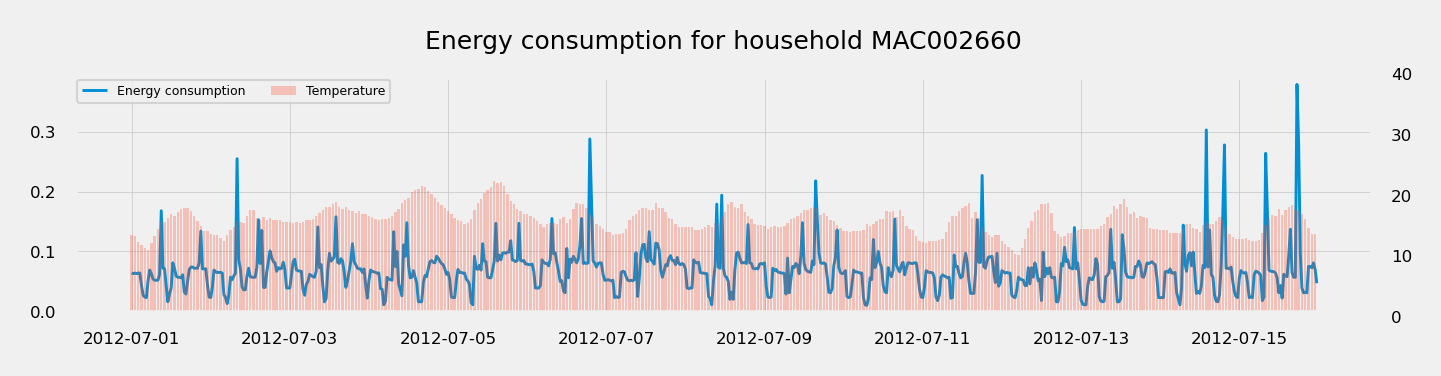

In [10]:
hhid = household_ids[2]
hh_energy = energy_df.loc[hhid, :]
start = '2012-07-01'
end = '2012-07-15'

fig = plt.figure(figsize=(5,1))
ax1 = fig.add_subplot(1,1,1)
plot1 = ax1.plot(hh_energy[start:end], label='Energy consumption', linewidth=0.7)
ax1.set_title(f'Energy consumption for household {hhid}')

ax2 = ax1.twinx()
plot2 = ax2.bar(x=weather_df.loc[start:end, 'temperature'].index, height=weather_df.loc[start:end, 'temperature'], color=colors[1], alpha=0.3, width=0.03, label='Temperature');
ax2.set_ylim((0,40))
ax2.grid(False)

labels = [plot1[0].get_label(), plot2.get_label()]
plt.legend(handles=[plot1[0], plot2], labels=labels, loc='upper left', fontsize=3, ncol=2)

plt.show()

In [11]:
acorn_filename = os.path.join(DATA, 'energy-london', 'acorn_details.csv')
acorn_df = pd.read_csv(acorn_filename, encoding='ISO-8859-1')
acorn_df = acorn_df.sample(10).loc[:, ['MAIN CATEGORIES', 'CATEGORIES', 'REFERENCE', 'ACORN-A', 'ACORN-B', 'ACORN-E']]
acorn_df

,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-E
411,DIGITAL,Types of internet usage : Mobile Phone,Download music via the Internet,136.0,107.0,141.0
46,HOUSING,House Size,Number of Beds : 1,29.0,23.0,133.0
584,DIGITAL,Sites regularly visited,Confused.com,101.0,117.0,100.0
466,DIGITAL,Types of internet usage : Tablet / iPad,Take part in discussion groups/online forums,92.0,116.0,117.0
449,DIGITAL,Types of internet usage : Tablet / iPad,Send and receive personal emails,126.0,131.0,123.0
687,SHOPPING,Attitudes,I tend to go for premium rather than standard ...,189.0,136.0,127.0
738,LEISURE TIME,Daily Newspapers,Daily Mail,139.0,139.0,97.0
56,HOUSING,House Value,House Value 750k-1m,156.0,317.0,94.0
367,DIGITAL,Types of internet usage : Laptop or PC,Instant messaging,97.0,95.0,119.0
219,FINANCE,Savings and Investments,Has investment bonds,216.0,204.0,119.0


## File structure exploration
---

In [68]:
from IPython.display import display_html

def display_multiple_dataframe(*args, max_rows=None, max_cols=None):
    html_str = ''
    for df in args:
        html_str += df.to_html(max_cols=max_cols, max_rows=max_rows)
        
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

In [80]:
display_multiple_dataframe(
    file_structure_df[['sensor_00']],
    file_structure_df[['sensor_01']],
    file_structure_df[['sensor_03']],
    max_rows=10, max_cols=None
)

,sensor_00
timestamp,
2018-04-01,2.445039
2018-04-06,2.424734
2018-04-11,2.191763
2018-04-16,2.102360
2018-04-21,2.411800
...,...
2018-08-09,2.457470
2018-08-14,2.444553
2018-08-19,2.477040


In [81]:
display_multiple_dataframe(
    file_structure_df.loc['2018-04', :].head(6),
    file_structure_df.loc['2018-05', :].head(6),
    file_structure_df.loc['2018-06', :].head(6),
    max_rows=None, max_cols=2
)

,sensor_00,...,sensor_09
timestamp,,,
2018-04-01,2.445039,...,15.094995
2018-04-06,2.424734,...,15.008543
2018-04-11,2.191763,...,14.910773
2018-04-16,2.102360,...,10.082631
2018-04-21,2.411800,...,15.081951
2018-04-26,2.462382,...,15.098790
,sensor_00,...,sensor_09
timestamp,,,
2018-05-01,2.453699,...,14.893017


In [82]:
display_multiple_dataframe(
    file_structure_df.loc['2018-04', ['sensor_00']].head(6),
    file_structure_df.loc['2018-05', ['sensor_00']].head(6),
    file_structure_df.loc['2018-06', ['sensor_00']].head(6),
    max_rows=10, max_cols=None
)
display_multiple_dataframe(
    file_structure_df.loc['2018-04', ['sensor_01']].head(6),
    file_structure_df.loc['2018-05', ['sensor_01']].head(6),
    file_structure_df.loc['2018-06', ['sensor_01']].head(6),
    max_rows=10, max_cols=None
)
print('.\n.\n.')
display_multiple_dataframe(
    file_structure_df.loc['2018-04', ['sensor_09']].head(6),
    file_structure_df.loc['2018-05', ['sensor_09']].head(6),
    file_structure_df.loc['2018-06', ['sensor_09']].head(6),
    max_rows=10, max_cols=None
)

,sensor_00
timestamp,
2018-04-01,2.445039
2018-04-06,2.424734
2018-04-11,2.191763
2018-04-16,2.102360
2018-04-21,2.411800
2018-04-26,2.462382
,sensor_00
timestamp,
2018-05-01,2.453699


,sensor_01
timestamp,
2018-04-01,48.994356
2018-04-06,48.648725
2018-04-11,49.748630
2018-04-16,43.144889
2018-04-21,49.088142
2018-04-26,46.729395
,sensor_01
timestamp,
2018-05-01,46.821613


.
.
.


,sensor_09
timestamp,
2018-04-01,15.094995
2018-04-06,15.008543
2018-04-11,14.910773
2018-04-16,10.082631
2018-04-21,15.081951
2018-04-26,15.098790
,sensor_09
timestamp,
2018-05-01,14.893017


In [121]:
df1 = pump_df.iloc[:, [0]].resample('5D').mean()
df2 = pump_df.iloc[:, [1]].resample('2D').mean()
df3 = pump_df.iloc[:, [2]].resample('7D').mean()

display_multiple_dataframe(
    df1.head(10), df2.head(10), df3.head(10),
    pd.merge(pd.merge(df1, df2, left_index=True, right_index=True, how='outer'), df3, left_index=True, right_index=True, how='outer').head(10),
    max_rows=None, max_cols=None
)

,sensor_00
timestamp,
2018-04-01,2.445039
2018-04-06,2.424734
2018-04-11,2.191763
2018-04-16,2.102360
2018-04-21,2.411800
2018-04-26,2.462382
2018-05-01,2.453699
2018-05-06,2.463929
2018-05-11,2.473434


In [120]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.merge(pd.merge(df1, df2, left_index=True, right_index=True, how='outer'), df3, left_index=True, right_index=True, how='outer').head(10)

,sensor_00,sensor_01,sensor_02
timestamp,,,
2018-04-01,2.445039,47.950337,52.096718
2018-04-03,NaN,49.848134,NaN
2018-04-05,NaN,50.218519,NaN
2018-04-06,2.424734,NaN,NaN
2018-04-07,NaN,46.951843,NaN
2018-04-08,NaN,NaN,51.030574
2018-04-09,NaN,49.127994,NaN
2018-04-11,2.191763,51.358596,NaN
2018-04-13,NaN,48.911794,NaN


In [30]:
colors

['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']

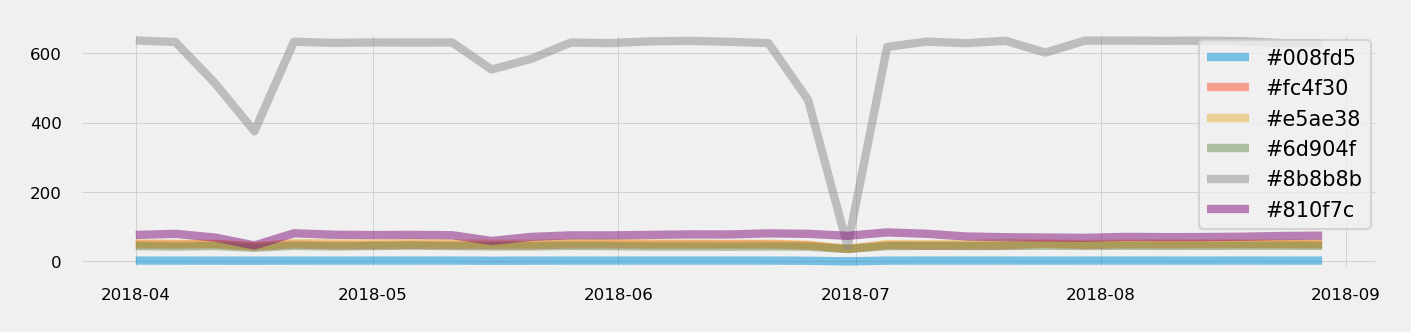

In [31]:
plt.figure(figsize=(5,1))
for i in range(len(colors)):
    plt.plot(file_structure_df[f'sensor_0{i}'], linewidth=2, alpha=0.5, label=colors[i])

plt.legend()
plt.show()

## Visualization
---

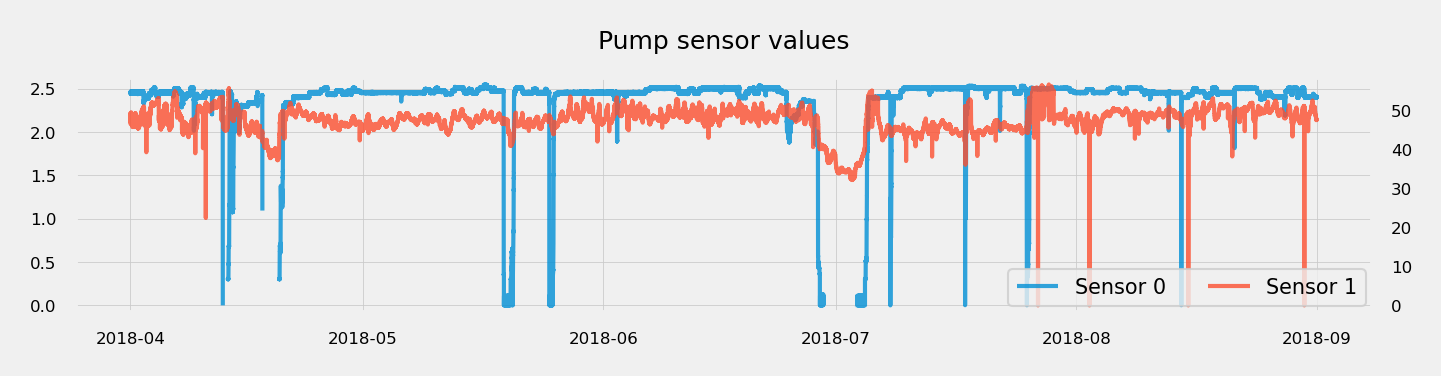

In [138]:
fig = plt.figure(figsize=(5,1))
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twinx()

plot_sensor_0 = ax1.plot(pump_df['sensor_00'], label='Sensor 0', color=colors[0], linewidth=1, alpha=0.8)
plot_sensor_1 = ax2.plot(pump_df['sensor_01'], label='Sensor 1', color=colors[1], linewidth=1, alpha=0.8)
ax2.grid(False)
plt.title('Pump sensor values (2 sensors)')
plt.legend(handles=[plot_sensor_0[0], plot_sensor_1[0]], ncol=2, loc='lower right')
plt.show()

In [167]:
reduced_pump_df = pump_df.loc[:, 'sensor_00':'sensor_14']
reduced_pump_df = reduced_pump_df.replace([np.inf, -np.inf], np.nan)
reduced_pump_df = reduced_pump_df.fillna(0.0)
reduced_pump_df = reduced_pump_df.astype(np.float32)
scaled_pump_df = pd.DataFrame(normalize(reduced_pump_df), index=reduced_pump_df.index, columns=reduced_pump_df.columns)
scaled_pump_df

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14
timestamp,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.092010,53.211800,46.310760,634.375000,76.459747,13.41146,16.131359,15.56713,15.05353,37.227402,47.524220,31.117161,1.681353,419.574707
2018-04-01 00:01:00,2.465394,47.092010,53.211800,46.310760,634.375000,76.459747,13.41146,16.131359,15.56713,15.05353,37.227402,47.524220,31.117161,1.681353,419.574707
2018-04-01 00:02:00,2.444734,47.352428,53.211800,46.397572,638.888916,73.545982,13.32465,16.037331,15.61777,15.01013,37.867771,48.177231,32.088940,1.708474,420.847992
2018-04-01 00:03:00,2.460474,47.092010,53.168400,46.397568,628.125000,76.988983,13.31742,16.247110,15.69734,15.08247,38.579769,48.656071,31.672211,1.579427,420.749390
2018-04-01 00:04:00,2.445718,47.135410,53.211800,46.397568,636.458313,76.588966,13.35359,16.210939,15.69734,15.08247,39.489391,49.062981,31.952021,1.683831,419.892609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 23:55:00,2.407350,47.699650,50.520828,43.142361,634.722229,64.590950,15.11863,16.652201,15.65393,15.16204,43.170849,54.160519,38.054241,13.265320,420.799286
2018-08-31 23:56:00,2.400463,47.699650,50.564240,43.142361,630.902771,65.833633,15.15480,16.702841,15.65393,15.11863,43.210381,54.526020,38.534851,13.242270,422.156708
2018-08-31 23:57:00,2.396528,47.699650,50.520828,43.142361,625.925903,67.294449,15.08970,16.702841,15.69734,15.11863,43.128361,55.117790,38.526779,13.188660,420.216614


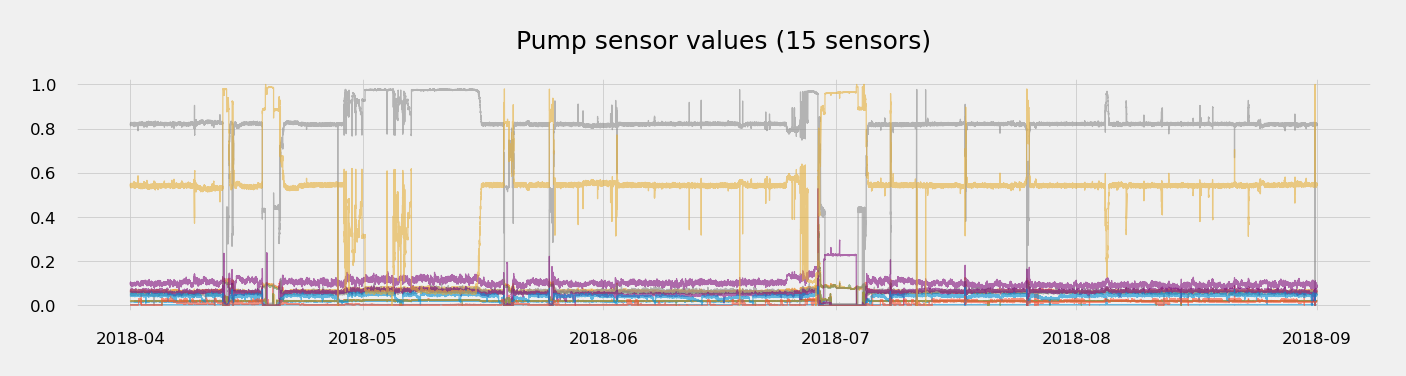

In [178]:
fig = plt.figure(figsize=(5,1))

for i in range(0,15):
    plt.plot(scaled_pump_df.iloc[:, i], alpha=0.6)

plt.title('Pump sensor values (15 sensors)')
plt.show()

In [218]:
pump_df2 = pump_df.copy()

pump_df2 = pump_df2.replace([np.inf, -np.inf], np.nan)
pump_df2 = pump_df2.fillna(0.0)
pump_df2 = pump_df2.astype(np.float32)

pump_description = pump_df2.describe().T
constant_signals = pump_description[pump_description['min'] == pump_description['max']].index.tolist()
pump_df2 = pump_df2.drop(columns=constant_signals)

features = pump_df2.columns.tolist()

In [222]:
pump_df2.shape[0] * pump_df2.shape[1]

11456640

In [269]:
def hex_to_rgb(hex_color):
    """
    Converts a color string in hexadecimal format to RGB format.
    
    PARAMS
    ======
        hex_color: string
            A string describing the color to convert from hexadecimal. It can
            include the leading # character or not
    
    RETURNS
    =======
        rgb_color: tuple
            Each color component of the returned tuple will be a float value
            between 0.0 and 1.0
    """
    hex_color = hex_color.lstrip('#')
    rgb_color = tuple(int(hex_color[i:i+2], base=16) / 255.0 for i in [0, 2, 4])
    return rgb_color

def plot_timeseries_strip_chart(binned_timeseries, signal_list, fig_width=12, signal_height=0.15, dates=None, day_interval=7):
    # Build a suitable colormap:
    colors_list = [
        hex_to_rgb('#DC322F'), 
        hex_to_rgb('#B58900'), 
        hex_to_rgb('#2AA198')
    ]
    cm = colors.LinearSegmentedColormap.from_list('RdAmGr', colors_list, N=len(colors_list))
    
    fig = plt.figure(figsize=(fig_width, signal_height * binned_timeseries.shape[0])) # 87
    ax = fig.add_subplot(1,1,1)
    
    # Devising the extent of the actual plot:
    if dates is not None:
        dnum = mdates.date2num(dates)
        start = dnum[0] - (dnum[1]-dnum[0])/2.
        stop = dnum[-1] + (dnum[1]-dnum[0])/2.
        extent = [start, stop, 0, signal_height * (binned_timeseries.shape[0])]
        
    else:
        extent = None
        
    # Plot the matrix:
    im = ax.imshow(binned_timeseries, 
                   extent=extent, 
                   aspect="auto", 
                   cmap=cm, 
                   origin='lower')
    
    # Adjusting the x-axis if we provide dates:
    if dates is not None:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(2)
            tick.label.set_rotation(60)
            tick.label.set_fontweight('bold')

        ax.xaxis.set_minor_locator(mdates.DayLocator(interval=day_interval))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
        for tick in ax.xaxis.get_minor_ticks():
            tick.label.set_fontsize(2)
            tick.label.set_rotation(90)
        
        ax.tick_params(axis='x', which='major', pad=7, labelcolor='#000000')
        plt.xticks(ha='right')
        
    # Adjusting the y-axis:
    ax.yaxis.set_major_locator(ticker.MultipleLocator(signal_height))
    ax.set_yticklabels(signal_list, verticalalignment='bottom', fontsize=2)
    ax.set_yticks(np.arange(len(signal_list)) * signal_height)

    plt.grid()
    return ax

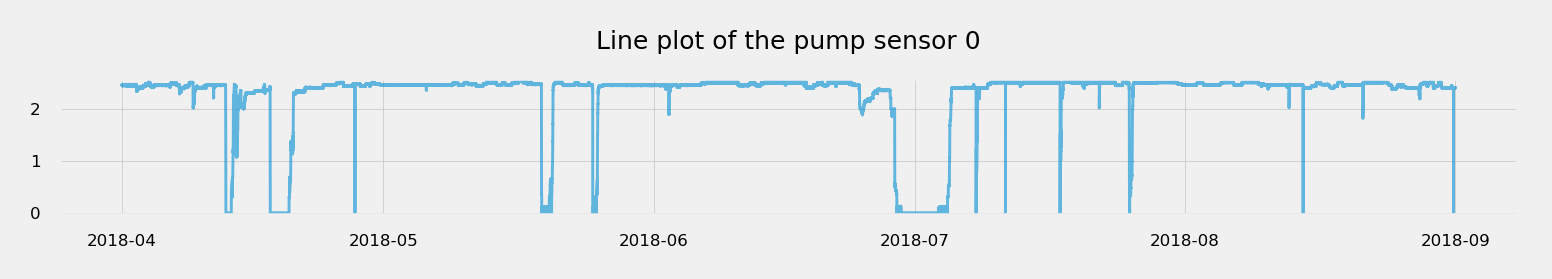

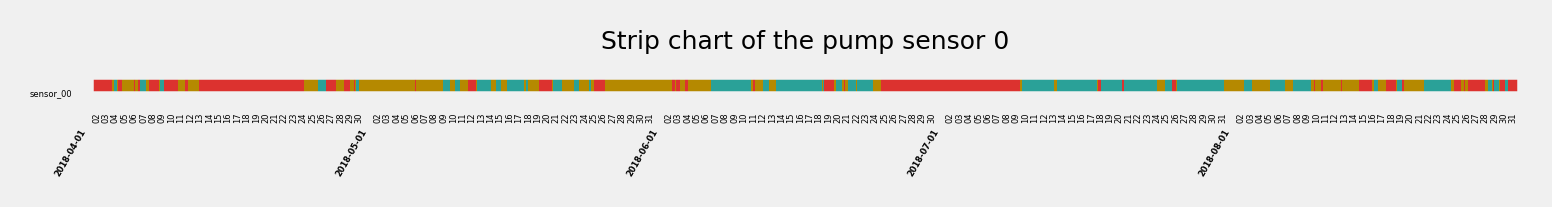

In [274]:
# Build a list of dataframes, one per sensor:
df_list = []
for f in features[:1]:
    df_list.append(pump_df2[[f]])

# Discretize each signal in 3 bins:
array = tsia.markov.discretize_multivariate(df_list)

fig = plt.figure(figsize=(5.62, 0.6))
plt.plot(pump_df2['sensor_00'], linewidth=0.7, alpha=0.6)
plt.title('Line plot of the pump sensor 0')
plt.show()

# Plot the strip chart:
ax = plot_timeseries_strip_chart(
    array, 
    signal_list=features[:1],
    fig_width=5.5,
    signal_height=0.1,
    dates=df_list[0].index.to_pydatetime(),
    day_interval=1
)
ax.set_title('Strip chart of the pump sensor 0');

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyts/preprocessing/discretizer.py:161: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  "of bins or removing these samples.".format(samples))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator


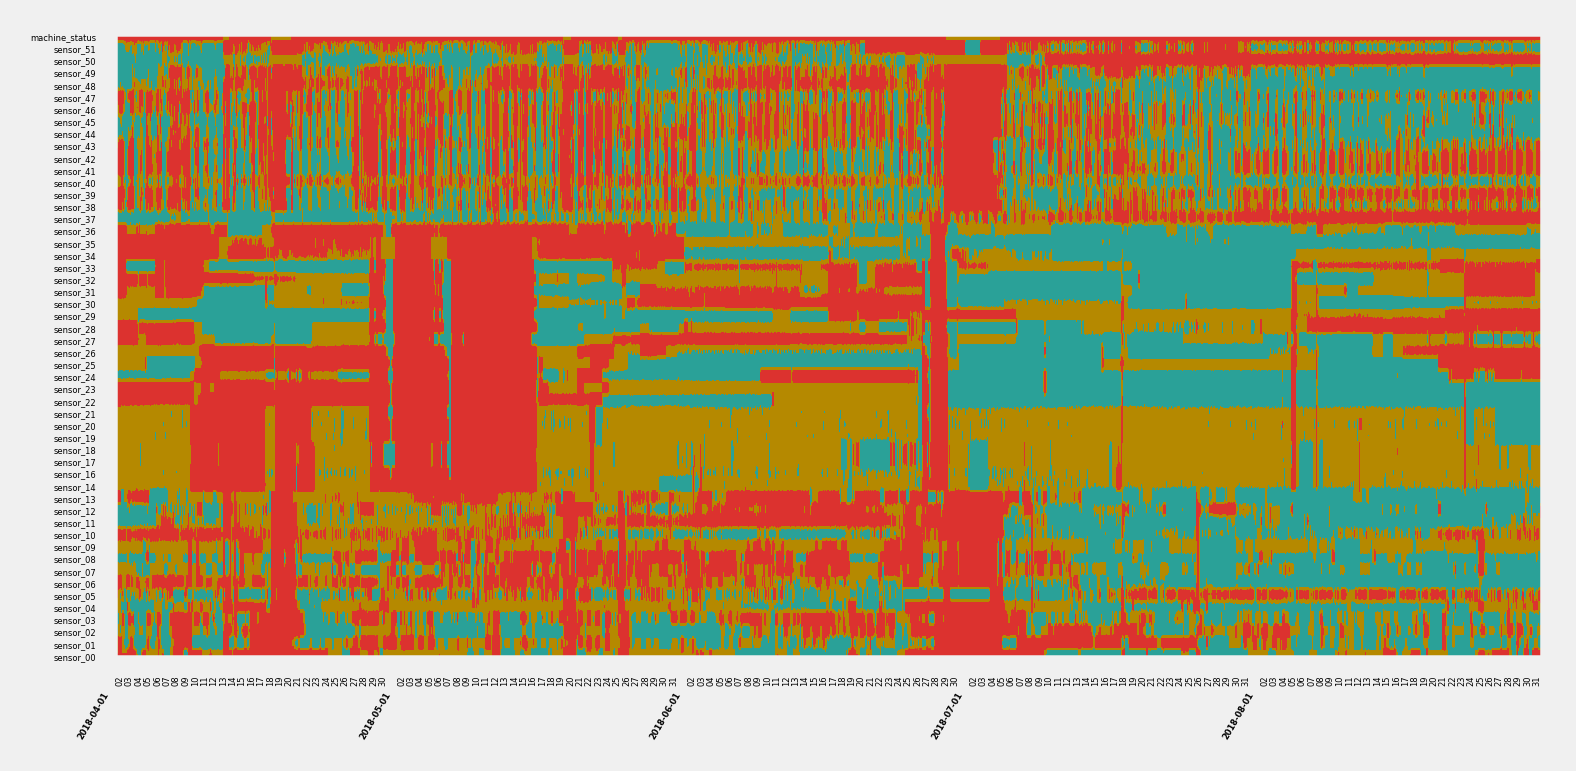

In [256]:
# Build a list of dataframes, one per sensor:
df_list = []
for f in features:
    df_list.append(pump_df2[[f]])

# Discretize each signal in 3 bins:
array = tsia.markov.discretize_multivariate(df_list)

# Plot the strip chart:
fig = plot_timeseries_strip_chart(
    array, 
    signal_list=features,
    fig_width=5.5,
    signal_height=0.05,
    dates=df_list[0].index.to_pydatetime(),
    day_interval=1
)

### Recurrence plot

In [15]:
weather_df

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
time,,,,,,,,
2011-11-23 10:00:00,6.24,233.0,5.74,5.46,1027.67,4.24,1.99,0.98
2011-11-23 11:00:00,10.20,233.0,7.67,5.74,1027.56,5.94,2.66,0.88
2011-11-23 12:00:00,11.62,234.0,8.84,6.52,1027.24,7.25,2.80,0.85
2011-11-23 13:00:00,12.68,233.0,9.87,6.99,1027.35,8.29,3.12,0.82
2011-11-23 14:00:00,12.25,232.0,10.36,7.75,1027.25,10.36,3.26,0.84
...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,14.03,220.0,5.94,2.07,1006.74,3.47,3.25,0.76
2014-02-27 21:00:00,16.09,217.0,5.03,1.67,1006.36,2.50,3.06,0.79
2014-02-27 22:00:00,14.00,216.0,4.10,1.64,1005.67,1.41,3.02,0.84


In [16]:
energy_df

energy
household_id timestamp                  
MAC002542    2012-07-09 11:30:00   0.037
             2012-07-09 12:00:00   0.106
             2012-07-09 12:30:00   0.094
             2012-07-09 13:00:00   0.196
             2012-07-09 13:30:00   0.281
...                                  ...
MAC001938    2014-02-27 22:00:00   0.030
             2014-02-27 22:30:00   0.030
             2014-02-27 23:00:00   0.032
             2014-02-27 23:30:00   0.033
             2014-02-28 00:00:00   0.033

[37645656 rows x 1 columns]

In [79]:
from pyts.image import RecurrencePlot
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField

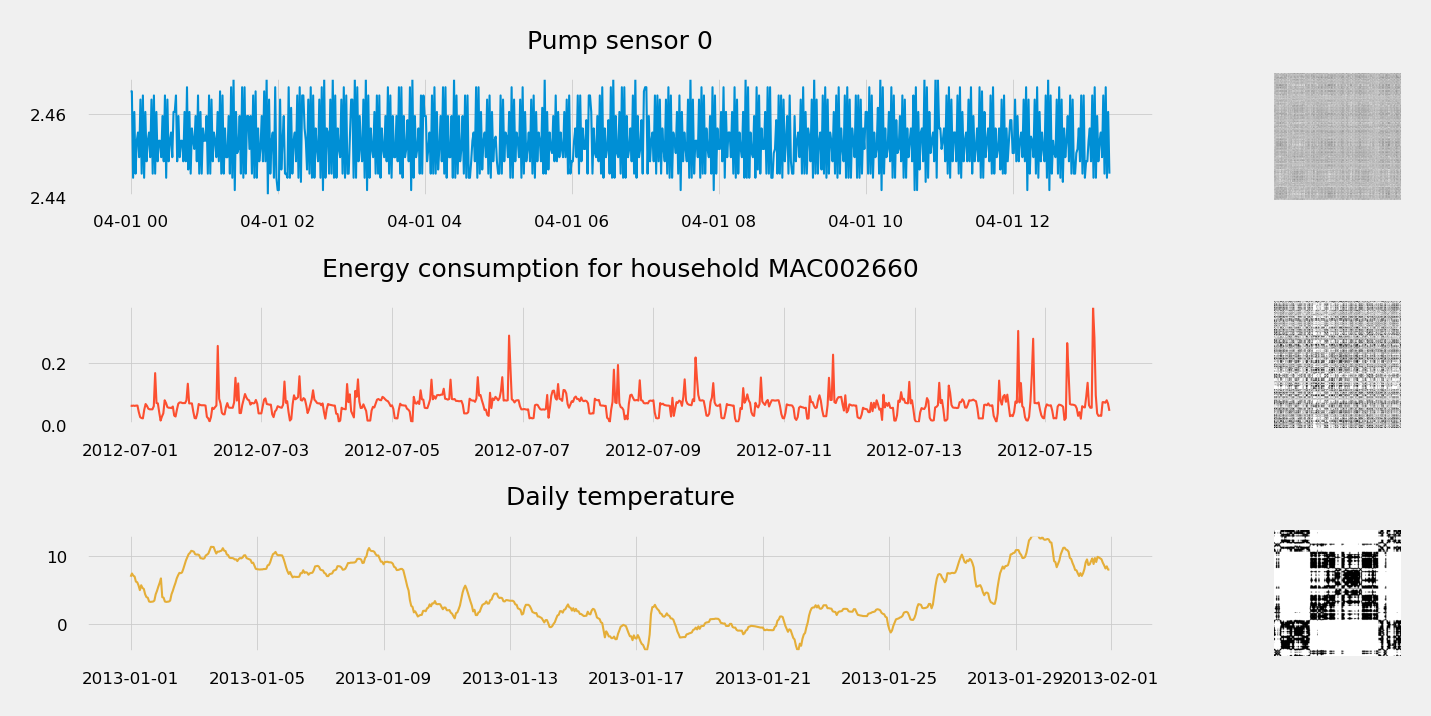

In [83]:
hhid = household_ids[2]
hh_energy = energy_df.loc[hhid, :]
pump_extract_df = pump_df.iloc[:800, 0].copy()

rp = RecurrencePlot(threshold='point', percentage=30)
weather_rp = rp.fit_transform(weather_df.loc['2013-01-01':'2013-01-31']['temperature'].values.reshape(1, -1))
energy_rp = rp.fit_transform(hh_energy['2012-07-01':'2012-07-15'].values.reshape(1, -1))
pump_rp = rp.fit_transform(pump_extract_df.values.reshape(1, -1))


fig = plt.figure(figsize=(5.5, 2.4))
gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[3,1], hspace=0.8, wspace=0.0)

# Pump sensor 0:
ax = fig.add_subplot(gs[0])
ax.plot(pump_extract_df, label='Pump sensor 0')
ax.set_title(f'Pump sensor 0')

ax = fig.add_subplot(gs[1])
ax.imshow(pump_rp[0], cmap='binary', origin='lower')
ax.axis('off')

# Energy consumption line plot and recurrence plot:
ax = fig.add_subplot(gs[2])
plot1 = ax.plot(hh_energy['2012-07-01':'2012-07-15'], color=colors[1])
ax.set_title(f'Energy consumption for household {hhid}')

ax = fig.add_subplot(gs[3])
ax.imshow(energy_rp[0], cmap='binary', origin='lower')
ax.axis('off')

# Daily temperature line plot and recurrence plot:
ax = fig.add_subplot(gs[4])
start = '2012-07-01'
end = '2012-07-15'
ax.plot(weather_df.loc['2013-01-01':'2013-01-31']['temperature'], color=colors[2])
ax.set_title(f'Daily temperature')

ax = fig.add_subplot(gs[5])
ax.imshow(weather_rp[0], cmap='binary', origin='lower')
ax.axis('off')

plt.show()

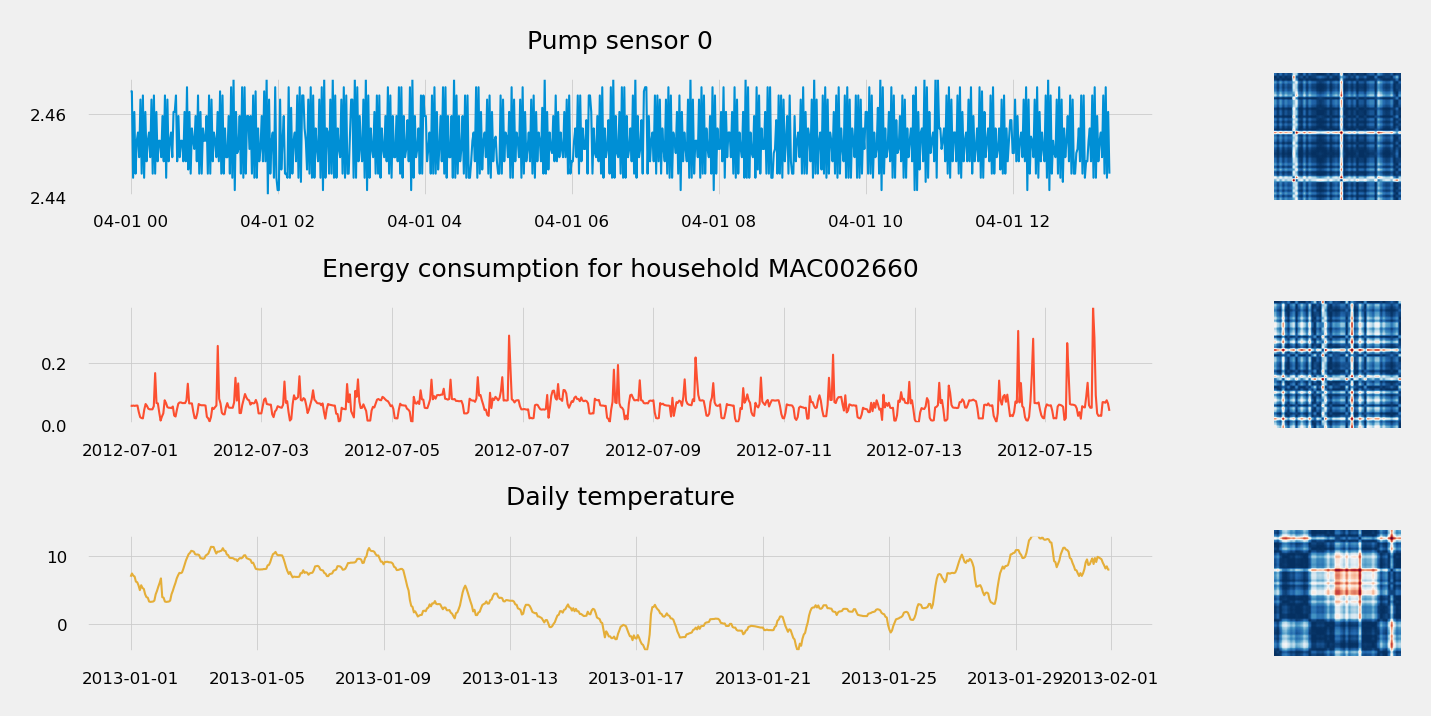

In [92]:
hhid = household_ids[2]
hh_energy = energy_df.loc[hhid, :]
pump_extract_df = pump_df.iloc[:800, 0].copy()

gaf = GramianAngularField(image_size=48, method='summation')
weather_gasf = gaf.fit_transform(weather_df.loc['2013-01-01':'2013-01-31']['temperature'].values.reshape(1, -1))
energy_gasf = gaf.fit_transform(hh_energy['2012-07-01':'2012-07-15'].values.reshape(1, -1))
pump_gasf = gaf.fit_transform(pump_extract_df.values.reshape(1, -1))

fig = plt.figure(figsize=(5.5, 2.4))
gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[3,1], hspace=0.8, wspace=0.0)

# Pump sensor 0:
ax = fig.add_subplot(gs[0])
ax.plot(pump_extract_df, label='Pump sensor 0')
ax.set_title(f'Pump sensor 0')

ax = fig.add_subplot(gs[1])
ax.imshow(pump_gasf[0], cmap='RdBu_r', origin='lower')
ax.axis('off')

# Energy consumption line plot and recurrence plot:
ax = fig.add_subplot(gs[2])
plot1 = ax.plot(hh_energy['2012-07-01':'2012-07-15'], color=colors[1])
ax.set_title(f'Energy consumption for household {hhid}')

ax = fig.add_subplot(gs[3])
ax.imshow(energy_gasf[0], cmap='RdBu_r', origin='lower')
ax.axis('off')

# Daily temperature line plot and recurrence plot:
ax = fig.add_subplot(gs[4])
start = '2012-07-01'
end = '2012-07-15'
ax.plot(weather_df.loc['2013-01-01':'2013-01-31']['temperature'], color=colors[2])
ax.set_title(f'Daily temperature')

ax = fig.add_subplot(gs[5])
ax.imshow(weather_gasf[0], cmap='RdBu_r', origin='lower')
ax.axis('off')

plt.show()

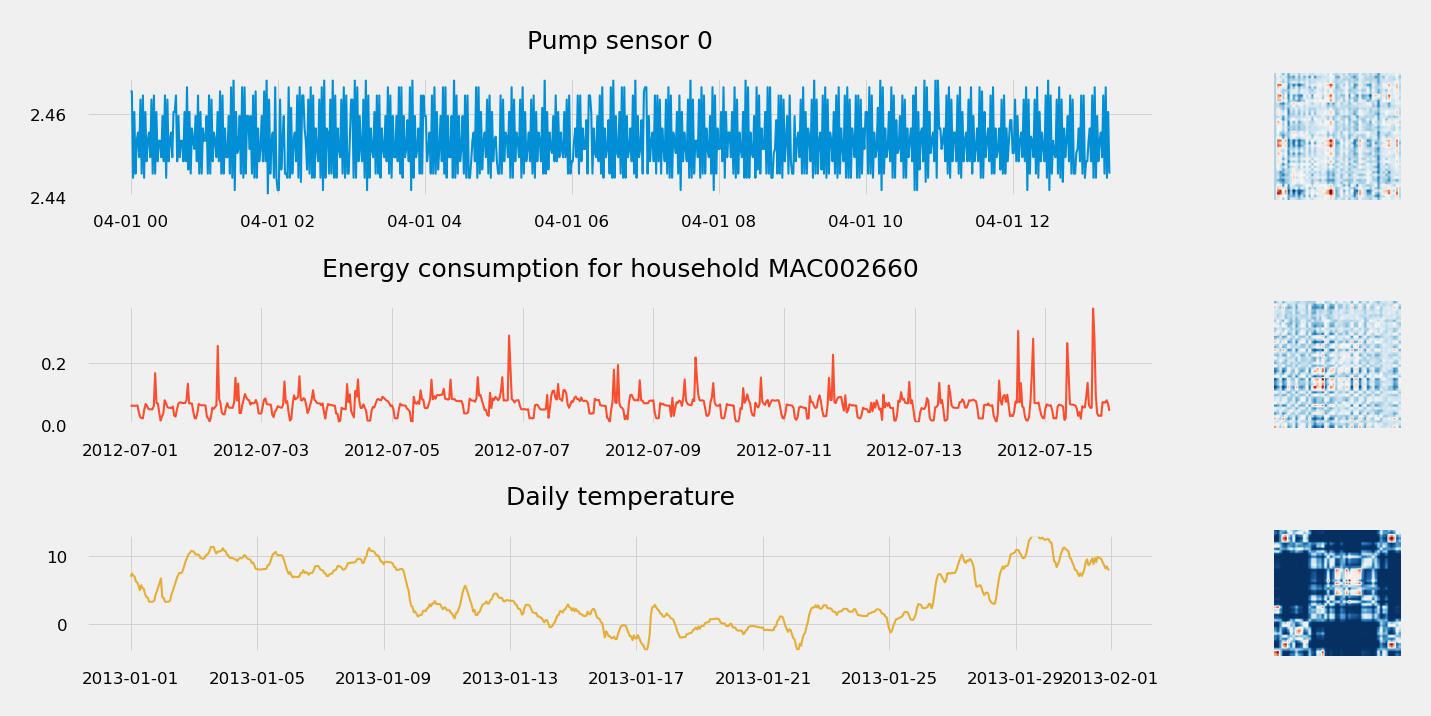

In [94]:
mtf = MarkovTransitionField(image_size=48)

weather_mtf = mtf.fit_transform(weather_df.loc['2013-01-01':'2013-01-31']['temperature'].values.reshape(1, -1))
energy_mtf = mtf.fit_transform(hh_energy['2012-07-01':'2012-07-15'].values.reshape(1, -1))
pump_mtf = mtf.fit_transform(pump_extract_df.values.reshape(1, -1))

fig = plt.figure(figsize=(5.5, 2.4))
gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[3,1], hspace=0.8, wspace=0.0)

# Pump sensor 0:
ax = fig.add_subplot(gs[0])
ax.plot(pump_extract_df, label='Pump sensor 0')
ax.set_title(f'Pump sensor 0')

ax = fig.add_subplot(gs[1])
ax.imshow(pump_mtf[0], cmap='RdBu_r', origin='lower')
ax.axis('off')

# Energy consumption line plot and recurrence plot:
ax = fig.add_subplot(gs[2])
plot1 = ax.plot(hh_energy['2012-07-01':'2012-07-15'], color=colors[1])
ax.set_title(f'Energy consumption for household {hhid}')

ax = fig.add_subplot(gs[3])
ax.imshow(energy_mtf[0], cmap='RdBu_r', origin='lower')
ax.axis('off')

# Daily temperature line plot and recurrence plot:
ax = fig.add_subplot(gs[4])
start = '2012-07-01'
end = '2012-07-15'
ax.plot(weather_df.loc['2013-01-01':'2013-01-31']['temperature'], color=colors[2])
ax.set_title(f'Daily temperature')

ax = fig.add_subplot(gs[5])
ax.imshow(weather_mtf[0], cmap='RdBu_r', origin='lower')
ax.axis('off')

plt.show()

In [105]:
import matplotlib
import matplotlib.cm as cm
import networkx as nx
import community

def compute_network_graph(markov_field):
    G = nx.from_numpy_matrix(markov_field[0])

    # Uncover the communities in the current graph:
    communities = community.best_partition(G)
    nb_communities = len(pd.Series(communities).unique())
    cmap = 'autumn'

    # Compute node colors and edges colors for the modularity encoding:
    edge_colors = [matplotlib.colors.to_hex(cm.get_cmap(cmap)(communities.get(v)/(nb_communities - 1))) for u,v in G.edges()]
    node_colors = [communities.get(node) for node in G.nodes()]
    node_size = [nx.average_clustering(G, [node])*90 for node in G.nodes()]

    # Builds the options set to draw the network graph in the "modularity" configuration:
    options = {
        'node_size': 10,
        'edge_color': edge_colors,
        'node_color': node_colors,
        'linewidths': 0,
        'width': 0.1,
        'alpha': 0.6,
        'with_labels': False,
        'cmap': cmap
    }
    
    return G, options

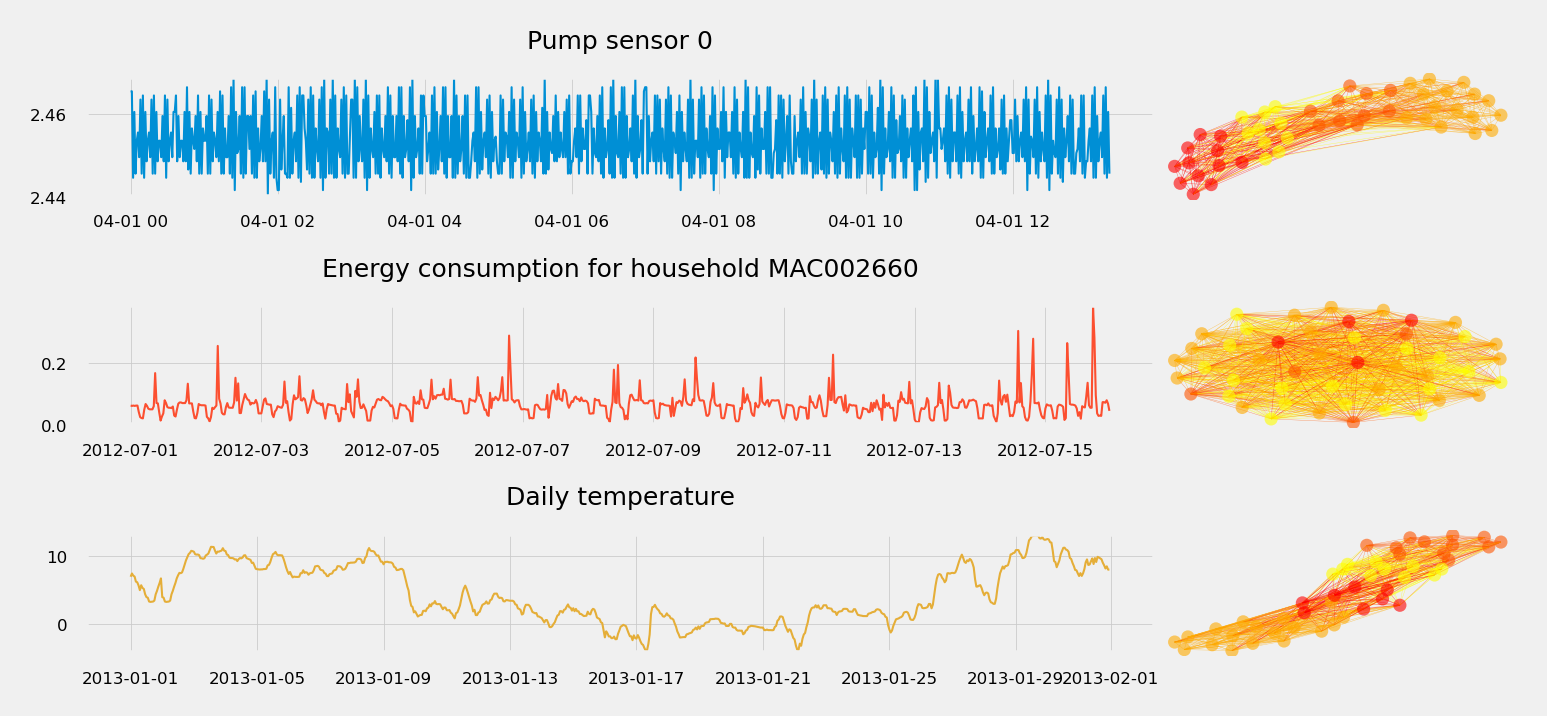

In [108]:
fig = plt.figure(figsize=(5.5, 2.4))
gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[3,1], hspace=0.8, wspace=0.0)

# Pump sensor 0:
ax = fig.add_subplot(gs[0])
ax.plot(pump_extract_df, label='Pump sensor 0')
ax.set_title(f'Pump sensor 0')

ax = fig.add_subplot(gs[1])
G, options = compute_network_graph(weather_mtf)
nx.draw_networkx(G, **options, pos=nx.spring_layout(G), ax=ax)
ax.axis('off')

# Energy consumption line plot and recurrence plot:
ax = fig.add_subplot(gs[2])
plot1 = ax.plot(hh_energy['2012-07-01':'2012-07-15'], color=colors[1])
ax.set_title(f'Energy consumption for household {hhid}')

ax = fig.add_subplot(gs[3])
G, options = compute_network_graph(energy_mtf)
nx.draw_networkx(G, **options, pos=nx.spring_layout(G), ax=ax)
ax.axis('off')

# Daily temperature line plot and recurrence plot:
ax = fig.add_subplot(gs[4])
start = '2012-07-01'
end = '2012-07-15'
ax.plot(weather_df.loc['2013-01-01':'2013-01-31']['temperature'], color=colors[2])
ax.set_title(f'Daily temperature')

ax = fig.add_subplot(gs[5])
G, options = compute_network_graph(weather_mtf)
nx.draw_networkx(G, **options, pos=nx.spring_layout(G), ax=ax)
ax.axis('off')

plt.show()

## Symbolic representation
---

In [214]:
from pyts.bag_of_words import BagOfWords

window_size, word_size = 30, 5
bow = BagOfWords(window_size=window_size, word_size=word_size, window_step=window_size, numerosity_reduction=False)
X = weather_df.loc['2013-01-01':'2013-01-31']['temperature'].values.reshape(1, -1)
X_bow = bow.transform(X)

In [133]:
time_index = weather_df.loc['2013-01-01':'2013-01-31']['temperature'].index

In [211]:
splits_series

array([  0,  31,  62,  93, 124, 155, 186, 217, 248, 279, 310, 341, 372,
       403, 434, 465, 496, 527, 558, 589, 620, 651, 682, 713, 744])

In [197]:
np.clip(splits_series[1:] + 1, 0, X.shape[1])

array([ 32,  63,  94, 125, 156, 187, 218, 249, 280, 311, 342, 373, 404,
       435, 466, 497, 528, 559, 590, 621, 652, 683, 714, 744])

In [207]:
splits_letters

array([  3,   9,  15,  21,  27,  33,  39,  45,  51,  57,  63,  69,  75,
        81,  87,  93,  99, 105, 111, 117, 123, 129, 135, 141, 147, 153,
       159, 165, 171, 177, 183, 189, 195, 201, 207, 213, 219, 225, 231,
       237, 243, 249, 255, 261, 267, 273, 279, 285, 291, 297, 303, 309,
       315, 321, 327, 333, 339, 345, 351, 357, 363, 369, 375, 381, 387,
       393, 399, 405, 411, 417, 423, 429, 435, 441, 447, 453, 459, 465,
       471, 477, 483, 489, 495, 501, 507, 513, 519, 525, 531, 537, 543,
       549, 555, 561, 567, 573, 579, 585, 591, 597, 603, 609, 615, 621,
       627, 633, 639, 645, 651, 657, 663, 669, 675, 681, 687, 693, 699,
       705, 711, 717, 723, 729, 735, 741])

In [213]:
len(X_bow[0].replace(' ', ''))

120

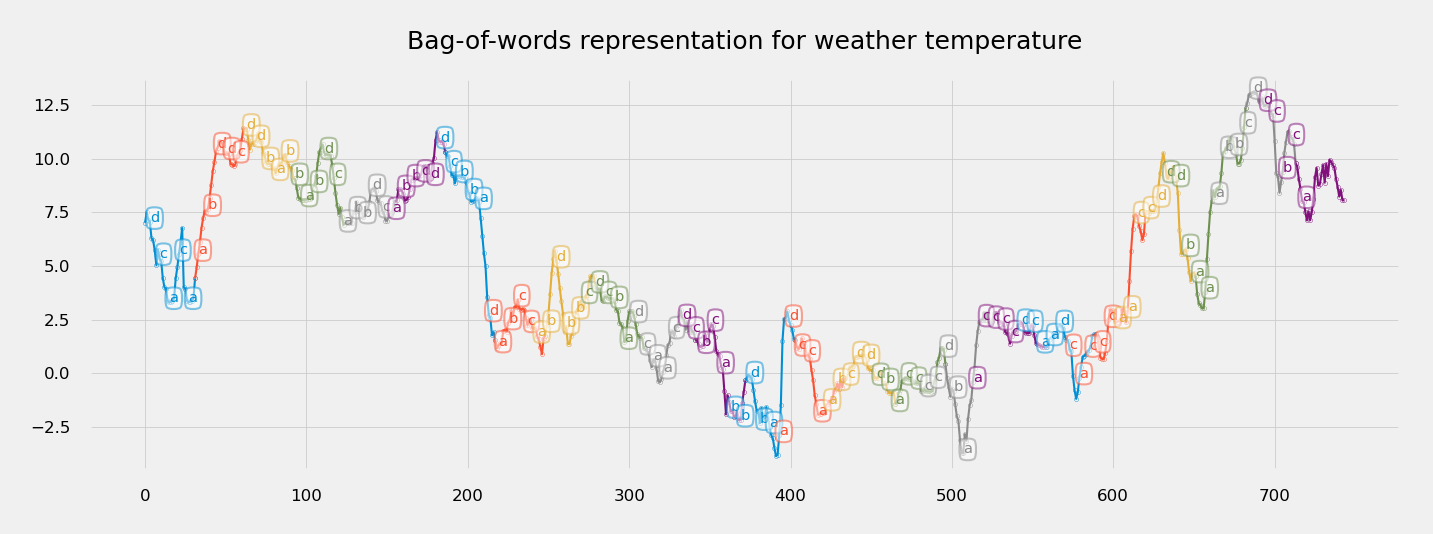

In [226]:
# Plot the considered subseries
plt.figure(figsize=(5, 2))
splits_series = np.linspace(0, X.shape[1], 1 + X.shape[1] // window_size, dtype='int64')
for start, end in zip(splits_series[:-1], np.clip(splits_series[1:] + 1, 0, X.shape[1])):
    plt.plot(np.arange(start, end), X[0, start:end], 'o-', linewidth=0.5, ms=0.1)

# Plot the corresponding letters
splits_letters = np.linspace(0, X.shape[1], 1 + word_size * X.shape[1] // window_size)
splits_letters = ((splits_letters[:-1] + splits_letters[1:]) / 2)
splits_letters = splits_letters.astype('int64')

for i, (x, text) in enumerate(zip(splits_letters, X_bow[0].replace(' ', ''))):
#     print(x, X[0, x])
    t = plt.text(x, X[0, x], text, color="C{}".format(i // 5), fontsize=3.5)
    t.set_bbox(dict(facecolor='#FFFFFF', alpha=0.5, edgecolor="C{}".format(i // 5), boxstyle='round4'))


# # plt.ylim((-1, 2.2))
# # plt.yticks(color='#FFFFFF')
# # plt.xticks(color='#FFFFFF')
# # plt.xlabel('Time')
plt.title('Bag-of-words representation for weather temperature')
plt.tight_layout()
# # plt.grid(color='#7b95b4')
# # plt.gca().patch.set_facecolor('#486180')
plt.show()

In [258]:
from pyts.transformation import WEASEL
from sklearn.preprocessing import LabelEncoder

In [259]:
# from pyts.datasets import load_basic_motions
# X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)

In [257]:
X_train.shape

(40, 6, 100)

In [244]:
ecg_df

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,-1.0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,...,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1.0,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,...,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1.0,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,...,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,-1.0,1.168874,2.075901,1.760140,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,...,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,1.0,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,...,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.581277,0.876188,1.042767,1.796120,2.541399,2.246653,1.500387,1.031521,0.382672,...,1.002770,0.907869,0.916457,0.923975,0.767357,0.656223,0.762357,0.501373,-0.333336,-0.524546
96,-1.0,2.689017,2.708703,2.008381,2.235800,1.516982,0.029916,-0.561346,-0.793702,-0.979371,...,-0.136610,-0.072176,-0.082738,-0.138468,-0.120396,-0.089411,-0.243141,-0.119710,0.124042,0.273463
97,-1.0,0.197677,0.455417,0.973110,1.935956,2.259463,1.741341,1.158296,0.418241,-0.071605,...,0.482452,0.325569,0.247991,0.184127,0.050358,0.241988,0.331451,-0.120006,0.042423,0.343293
98,1.0,0.179500,1.038409,1.946421,2.705141,1.670706,-0.101167,-1.578876,-0.750906,0.175310,...,0.324323,0.330489,0.111953,0.448948,0.567132,0.136757,0.444768,0.151050,0.193378,0.451709


In [295]:
X_train = ecg_df.iloc[:, 1:].values
y_train = ecg_df.iloc[:, 0]
y_train = LabelEncoder().fit_transform(y_train)
weasel = WEASEL(word_size=3, n_bins=3, window_sizes=[10, 25], sparse=False)
X_weasel = weasel.fit_transform(X_train, y_train)
vocabulary_length = len(weasel.vocabulary_)

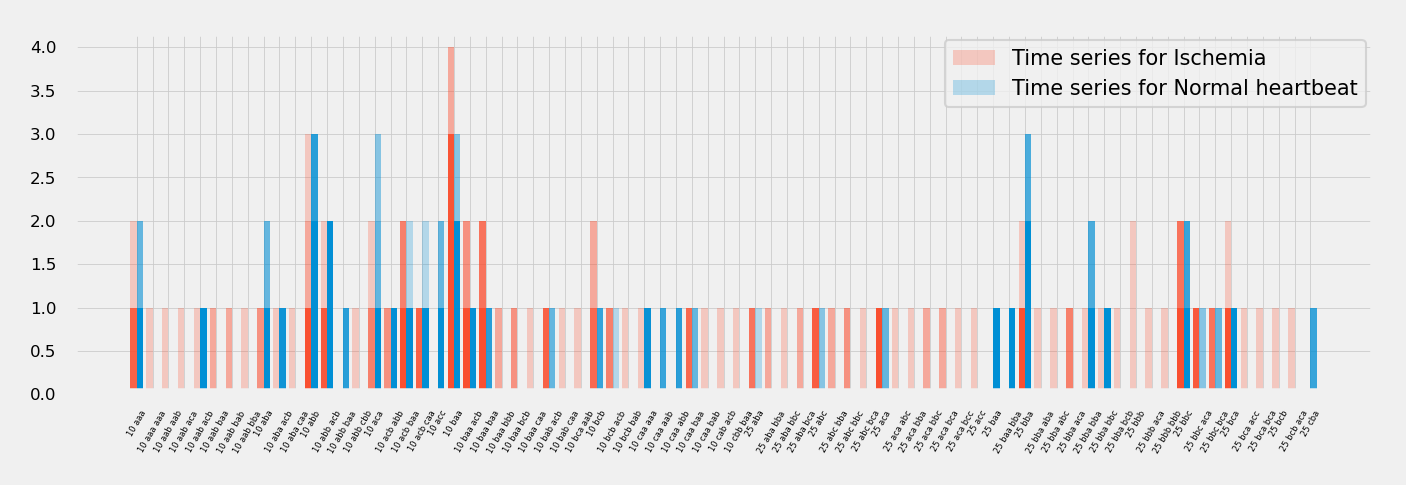

In [299]:
plt.figure(figsize=(5,1.5))
width = 0.4
x = np.arange(vocabulary_length) - width / 2
for i in range(len(X_weasel[y_train == 0])):
    if i == 0:
        plt.bar(x, X_weasel[y_train == 0][i], width=width, alpha=0.25, color=colors[1], label='Time series for Ischemia')
    else:
        plt.bar(x, X_weasel[y_train == 0][i], width=width, alpha=0.25, color=colors[1])
    
for i in range(len(X_weasel[y_train == 1])):
    if i == 0:
        plt.bar(x+width, X_weasel[y_train == 1][i], width=width, alpha=0.25, color=colors[0], label='Time series for Normal heartbeat')
    else:
        plt.bar(x+width, X_weasel[y_train == 1][i], width=width, alpha=0.25, color=colors[0])
        
plt.xticks(
    np.arange(vocabulary_length),
    np.vectorize(weasel.vocabulary_.get)(np.arange(X_weasel[0].size)),
    fontsize=2,
    rotation=60
)
    
plt.legend(loc='upper right')
plt.show()

## Statistics
---

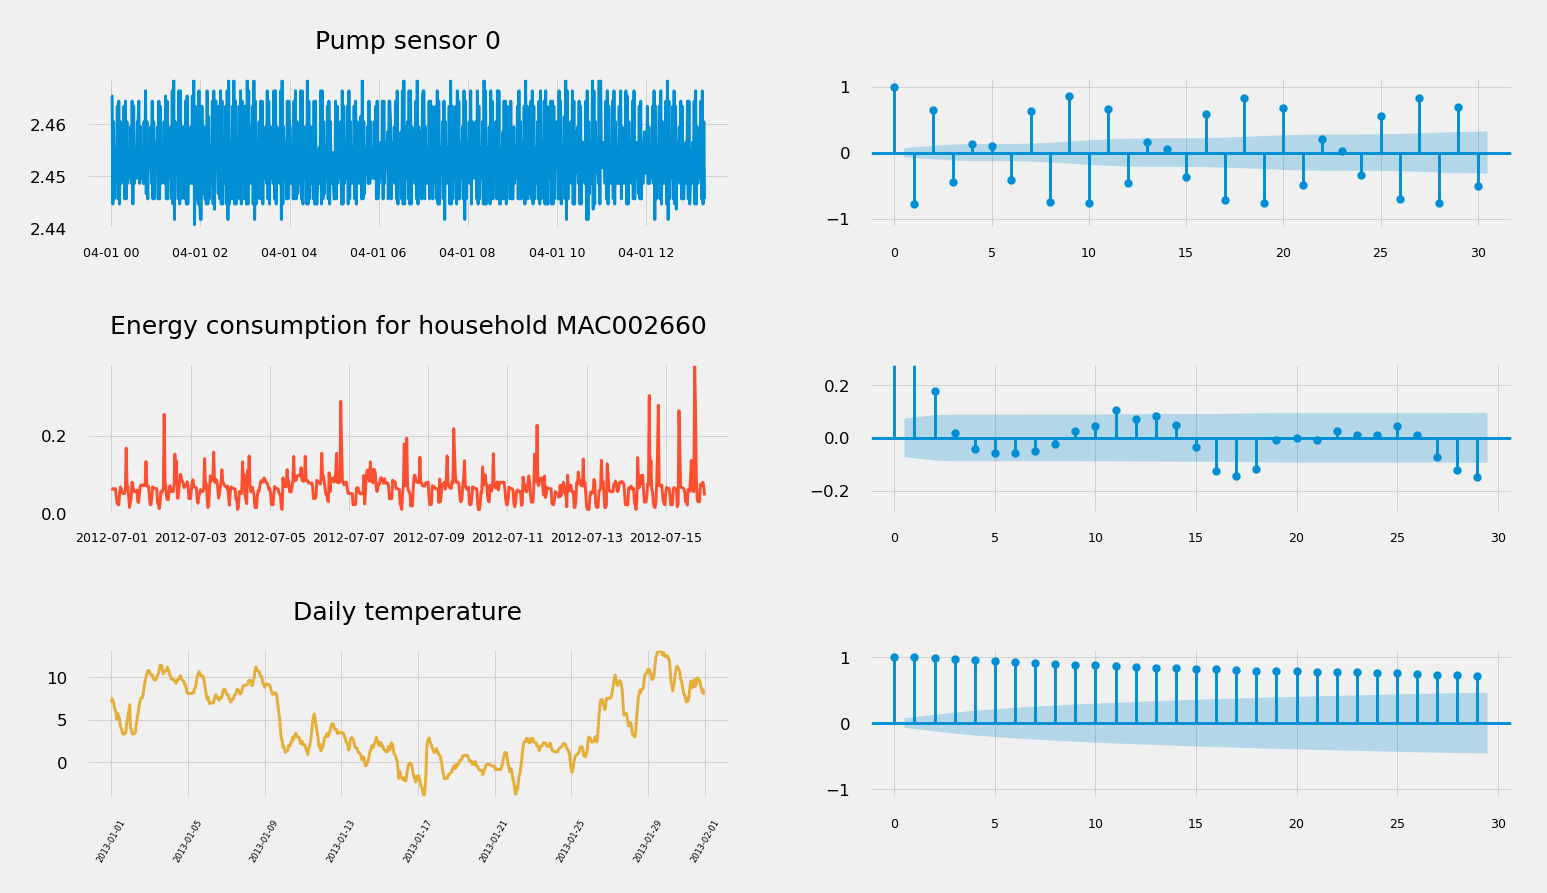

In [345]:
plt.rcParams['xtick.labelsize'] = 3

import statsmodels.api as sm

fig = plt.figure(figsize=(5.5, 3))
gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[1,1], hspace=0.8)

# Pump
ax = fig.add_subplot(gs[0])
ax.plot(pump_extract_df, label='Pump sensor 0')
ax.set_title(f'Pump sensor 0')
ax = fig.add_subplot(gs[1])
sm.graphics.tsa.plot_acf(pump_extract_df.values.squeeze(), ax=ax, markersize=1, title='')
ax.set_ylim(-1.2, 1.2)

# Energy consumption
ax = fig.add_subplot(gs[2])
ax.plot(hh_energy['2012-07-01':'2012-07-15'], color=colors[1])
ax.set_title(f'Energy consumption for household {hhid}')
ax = fig.add_subplot(gs[3])
sm.graphics.tsa.plot_acf(hh_energy['2012-07-01':'2012-07-15'].values.squeeze(), ax=ax, markersize=1, title='')
ax.set_ylim(-0.3, 0.3)

# Daily temperature:
ax = fig.add_subplot(gs[4])
start = '2012-07-01'
end = '2012-07-15'
ax.plot(weather_df.loc['2013-01-01':'2013-01-31']['temperature'], color=colors[2])
ax.set_title(f'Daily temperature')
plt.xticks(rotation=60, fontsize=2)

ax = fig.add_subplot(gs[5])
sm.graphics.tsa.plot_acf(weather_df.loc['2013-01-01':'2013-01-31']['temperature'].values.squeeze(), ax=ax, markersize=1, title='')
ax.set_ylim(-1.2, 1.2)

plt.show()

In [369]:
from statsmodels.tsa.seasonal import STL

endog = endog.resample('30T').mean()
endog

timestamp
2012-07-01 00:00:00    0.064
2012-07-01 00:30:00    0.063
2012-07-01 01:00:00    0.064
2012-07-01 01:30:00    0.063
2012-07-01 02:00:00    0.064
                       ...  
2012-07-15 21:30:00    0.075
2012-07-15 22:00:00    0.073
2012-07-15 22:30:00    0.081
2012-07-15 23:00:00    0.070
2012-07-15 23:30:00    0.047
Freq: 30T, Name: energy, Length: 720, dtype: float64

In [383]:
endog

timestamp
2012-07-01 00:00:00    0.064
2012-07-01 00:30:00    0.063
2012-07-01 01:00:00    0.064
2012-07-01 01:30:00    0.063
2012-07-01 02:00:00    0.064
                       ...  
2012-07-15 21:30:00    0.075
2012-07-15 22:00:00    0.073
2012-07-15 22:30:00    0.081
2012-07-15 23:00:00    0.070
2012-07-15 23:30:00    0.047
Name: energy, Length: 720, dtype: float64

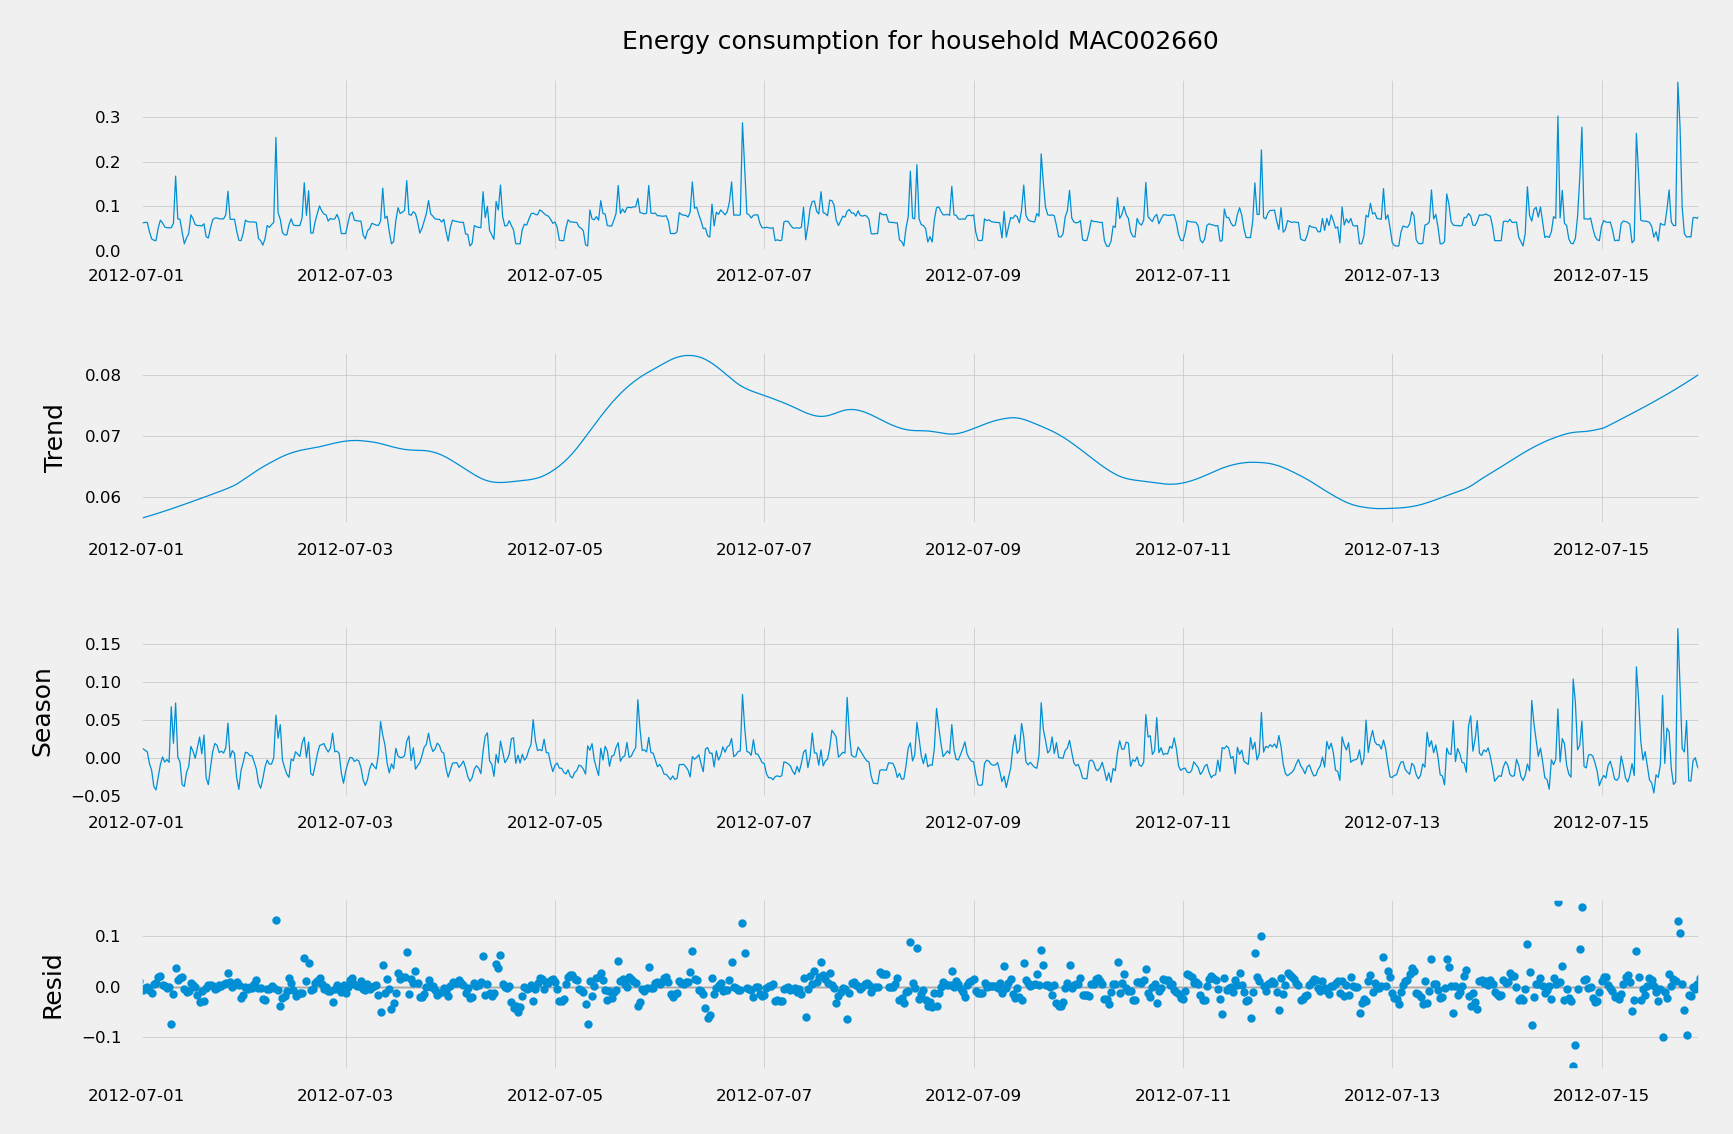

In [384]:
plt.rcParams['lines.markersize'] = 1

title = f'Energy consumption for household {hhid}'
endog = hh_energy['2012-07-01':'2012-07-15']
endog.columns = [title]
endog = endog[title]
stl = STL(endog, period=48)
res = stl.fit()
fig = res.plot()
plt.show()

In [387]:
!pip install --quiet ruptures

In [388]:
import ruptures as rpt

In [441]:
signal = weather_df.loc['2013-01-01':'2013-01-31']['temperature'].values.squeeze()
algo = rpt.Binseg(model='l2').fit(signal)
my_bkps = algo.predict(n_bkps=3)

In [442]:
my_bkps = [0] + my_bkps
my_bkps

[0, 35, 210, 610, 744]

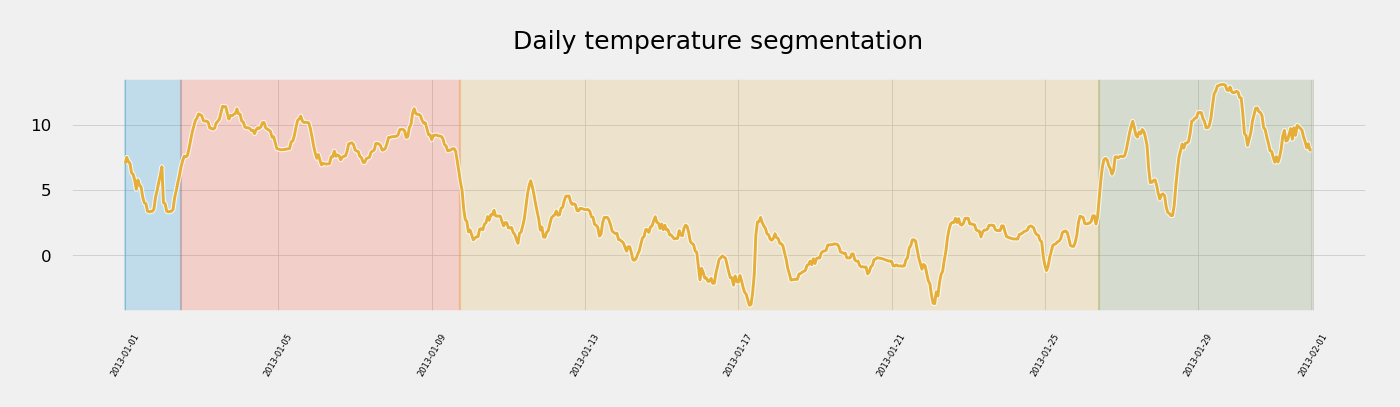

In [443]:
fig = plt.figure(figsize=(5,1))
start = '2012-07-01'
end = '2012-07-15'
plt.plot(weather_df.loc['2013-01-01':'2013-01-31']['temperature'], color='#FFFFFF', linewidth=1.2, alpha=0.8)
plt.plot(weather_df.loc['2013-01-01':'2013-01-31']['temperature'], color=colors[2], linewidth=0.7)

plt.title(f'Daily temperature')
plt.xticks(rotation=60, fontsize=2)

weather_index = weather_df.loc['2013-01-01':'2013-01-31']['temperature'].index

for index, bkps in enumerate(my_bkps[:-1]):
    x1 = weather_index[my_bkps[index]]
    x2 = weather_index[np.clip(my_bkps[index+1], 0, len(weather_index)-1)]
    
    plt.axvspan(x1, x2, color=colors[index % 5], alpha=0.2)

plt.title('Daily temperature segmentation')
plt.show()